# Libraries

In [1]:
!pip install arch

In [2]:
!pip install statsmodels

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM, InputLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from google.colab import drive
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from tensorflow.keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Lambda
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping



from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf



In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ATSF/Cryptocurrency-Prediction-with-Artificial-Intelligence')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LSTM and NN Config:

In [5]:
def set_np_and_tf_seed():
  # Set the seed for TensorFlow
  tf.random.set_seed(42)
  # Optionally set the seed for NumPy if you haven't set it before and if you're using NumPy arrays directly in your model
  np.random.seed(42)

set_np_and_tf_seed()

# TODO:

In [6]:
# General
year_length=365
aim="Close"

# LSTM:
univariate=True

window_len = 6
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
shuffle=True

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    min_delta=0.00001,      # Minimum change detected as an improvement
    patience=5,          # Stops after 10 epochs of no improvements
    verbose=1,            # Prints out messages
    mode='min',           # Stops when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)


## Absolute LPD
k = 1  # Example feature index
quantile_select = 1 - 1/7
length_roll_quantile = 30  # Using one month

## Random LPD
num_nets=20

variaten=['High','Low','Open','Close']


# Reading Data for our case Ethereum:

In [7]:
data_eth = pd.read_csv("eth_hist.csv")
print(data_eth.head(0))
data_eth = data_eth.loc[:,['Date','High','Low','Open','Volume',aim]]
print(data_eth.head(5))
print(data_eth.Date)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits]
Index: []
                        Date        High         Low        Open      Volume  \
0  2017-11-09 00:00:00+00:00  329.451996  307.056000  308.644989   893249984   
1  2017-11-10 00:00:00+00:00  324.717987  294.541992  320.670990   885985984   
2  2017-11-11 00:00:00+00:00  319.453003  298.191986  298.585999   842300992   
3  2017-11-12 00:00:00+00:00  319.153015  298.513000  314.690002  1613479936   
4  2017-11-13 00:00:00+00:00  328.415009  307.024994  307.024994  1041889984   

        Close  
0  320.884003  
1  299.252991  
2  314.681000  
3  307.907990  
4  316.716003  
0       2017-11-09 00:00:00+00:00
1       2017-11-10 00:00:00+00:00
2       2017-11-11 00:00:00+00:00
3       2017-11-12 00:00:00+00:00
4       2017-11-13 00:00:00+00:00
                  ...            
2309    2024-03-06 00:00:00+00:00
2310    2024-03-07 00:00:00+00:00
2311    2024-03-08 00:00:00+00:00
2312    2024-03-09

In [8]:
data_eth = data_eth.set_index('Date').sort_values('Date', ascending=True)
data_eth.index = pd.to_datetime(data_eth.index,unit='ns')
print(data_eth.index)

DatetimeIndex(['2017-11-09 00:00:00+00:00', '2017-11-10 00:00:00+00:00',
               '2017-11-11 00:00:00+00:00', '2017-11-12 00:00:00+00:00',
               '2017-11-13 00:00:00+00:00', '2017-11-14 00:00:00+00:00',
               '2017-11-15 00:00:00+00:00', '2017-11-16 00:00:00+00:00',
               '2017-11-17 00:00:00+00:00', '2017-11-18 00:00:00+00:00',
               ...
               '2024-03-01 00:00:00+00:00', '2024-03-02 00:00:00+00:00',
               '2024-03-03 00:00:00+00:00', '2024-03-04 00:00:00+00:00',
               '2024-03-05 00:00:00+00:00', '2024-03-06 00:00:00+00:00',
               '2024-03-07 00:00:00+00:00', '2024-03-08 00:00:00+00:00',
               '2024-03-09 00:00:00+00:00', '2024-03-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2314, freq=None)


In [9]:
train_data_eth = data_eth.iloc[:-200]
test_data_eth = data_eth.iloc[-200:]


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('ETH', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

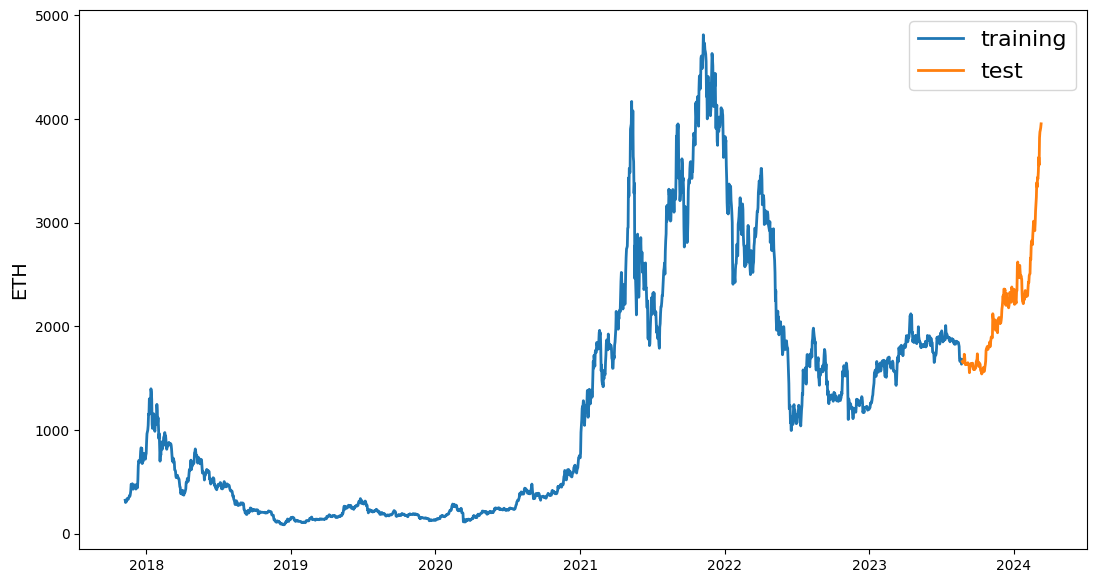

In [10]:
line_plot(train_data_eth[aim], test_data_eth[aim], 'training', 'test', title='')

# Univariate Data processing and Data modeling (using LSTM) for Ethereum dataset in addition to using LPD

## Preparing Data for LSTM



In [11]:
# makes the scale of all the columns the same:
def normalise_zero_base(continuous):
    # Using np.finfo to safely get a small positive number close to zero
    base_value = continuous.iloc[0] + np.finfo(float).eps
    return (continuous / base_value) - 1

def normalise_min_max(data,continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())


# Calculating the Lags for training
def extract_window_data(continuous, window_len, zero_base=True,debug=False):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if debug:
          print ("Input to normalize_zero_base:\n",tmp)
        if zero_base:
            tmp = normalise_zero_base(tmp)
            if debug:
              print("Normalise_zero_base: \n",tmp)
        window_data.append(tmp.values)
        if debug:
          print("window_data:\n",window_data)
    if debug:
      print("window_data final:\n",window_data)
    return np.array(window_data)





In [12]:
def prepare_data(train_data, test_data, continuous, aim,window_len=6, zero_base=True,test_size=None, log_returns=False, univariate=False,debug=False):
    #if we do Log_returns we don't want to zero_base, so we set zero_base=False
    tmp_train_data=train_data.copy(deep=True)
    tmp_test_data=test_data.copy(deep=True)
    train_data=train_data[variaten]
    test_data=test_data[variaten]
    if debug:
      print(train_data)
    if log_returns:
        zero_base=False
        print("Original Train Data:\n", train_data.head())
        train_data_log = np.log(train_data).diff().dropna()
        test_data_log = np.log(test_data).diff().dropna()

        print("Logged and Differenced Train Data:\n", train_data_log[:10])
        if univariate:
            train_data_log = train_data_log[[aim]]
            test_data_log = test_data_log[[aim]]


        y_train = train_data_log[aim][window_len:].values
        print("y_train \n", y_train)
        y_test = test_data_log[aim][window_len:].values


        train_data_log = extract_window_data(train_data_log, window_len, zero_base,debug)
        test_data_log = extract_window_data(test_data_log, window_len, zero_base,debug=False)

        X_train = train_data_log
        print("X_train \n", X_train)
        X_test = test_data_log


        if zero_base:
            y_train = y_train / train_data_log[aim][:-window_len].values - 1
            y_test = y_test / test_data_log[aim][:-window_len].values - 1
    else:
        train_data_univ = train_data
        test_data_univ = test_data
        if univariate:
            train_data_univ = train_data[[aim]]
            test_data_univ = test_data[[aim]]
        X_train = extract_window_data(train_data_univ, window_len, zero_base,debug)
        print("X_train:\n", X_train[:10])
        X_test = extract_window_data(test_data_univ, window_len, zero_base,debug=False)
        y_train = train_data_univ[aim][window_len:].values
        y_test = test_data_univ[aim][window_len:].values
        print("Original y_test:\n", y_test[:10])
        if zero_base:
            y_train = y_train / train_data_univ[aim][:-window_len].values - 1
            y_test = y_test / test_data_univ[aim][:-window_len].values - 1

    return tmp_train_data, tmp_test_data, X_train, X_test, y_train, y_test

### Debugging the code above

In [13]:
data_zero_base = {
    'High': [329.45, 324.71, 319.45, 319.15, 328.41],
    'Low': [307.05, 294.54, 298.19, 298.51, 307.02],
    'Open': [308.64, 320.67, 298.58, 314.69, 307.02],
    'Volume': [893249984, 885985984, 842300992, 1613479936, 1041889984],
    aim: [320.88, 299.25, 314.68, 307.90, 316.71]
}
df_zero_base = pd.DataFrame(data_zero_base)
print(df_zero_base)


t_data,_,x_t,_,y_t,_=prepare_data(df_zero_base,df_zero_base, None, aim, window_len=2, zero_base=zero_base, test_size=None,log_returns=False,univariate=True,debug=True)
print("t_data\n",t_data,"\nX input to LSTM\n",x_t,"\ny input to LSTM:\n",y_t)



     High     Low    Open      Volume   Close
0  329.45  307.05  308.64   893249984  320.88
1  324.71  294.54  320.67   885985984  299.25
2  319.45  298.19  298.58   842300992  314.68
3  319.15  298.51  314.69  1613479936  307.90
4  328.41  307.02  307.02  1041889984  316.71
     High     Low    Open   Close
0  329.45  307.05  308.64  320.88
1  324.71  294.54  320.67  299.25
2  319.45  298.19  298.58  314.68
3  319.15  298.51  314.69  307.90
4  328.41  307.02  307.02  316.71
Input to normalize_zero_base:
     Close
0  320.88
1  299.25
Normalise_zero_base: 
       Close
0  0.000000
1 -0.067408
window_data:
 [array([[ 0.        ],
       [-0.06740838]])]
Input to normalize_zero_base:
     Close
1  299.25
2  314.68
Normalise_zero_base: 
       Close
1  0.000000
2  0.051562
window_data:
 [array([[ 0.        ],
       [-0.06740838]]), array([[0.        ],
       [0.05156224]])]
Input to normalize_zero_base:
     Close
2  314.68
3  307.90
Normalise_zero_base: 
       Close
2  0.000000
3 -0.0

In [14]:
t_data,_,x_t,_,y_t,_=prepare_data(df_zero_base,df_zero_base, None, aim, window_len=2, zero_base=zero_base, test_size=None,log_returns=True,univariate=False,debug=True)
print("t_data\n",t_data,"\nx_t\n",x_t,"\ny_t\n",y_t)

     High     Low    Open   Close
0  329.45  307.05  308.64  320.88
1  324.71  294.54  320.67  299.25
2  319.45  298.19  298.58  314.68
3  319.15  298.51  314.69  307.90
4  328.41  307.02  307.02  316.71
Original Train Data:
      High     Low    Open   Close
0  329.45  307.05  308.64  320.88
1  324.71  294.54  320.67  299.25
2  319.45  298.19  298.58  314.68
3  319.15  298.51  314.69  307.90
4  328.41  307.02  307.02  316.71
Logged and Differenced Train Data:
        High       Low      Open     Close
1 -0.014492 -0.041596  0.038237 -0.069788
2 -0.016332  0.012316 -0.071375  0.050277
3 -0.000940  0.001073  0.052550 -0.021781
4  0.028602  0.028109 -0.024675  0.028211
y_train 
 [-0.02178119  0.02821147]
Input to normalize_zero_base:
        High       Low      Open     Close
1 -0.014492 -0.041596  0.038237 -0.069788
2 -0.016332  0.012316 -0.071375  0.050277
window_data:
 [array([[-0.01449212, -0.04159578,  0.03823701, -0.06978788],
       [-0.01633171,  0.01231605, -0.07137465,  0.05027

In [15]:
319.45/329.45-1

-0.030353619669145515

## Building LSTM Model:

We only use one variable, namely close

In [16]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model





In [17]:
# prepare_data doesn't change train_data_eth, test_data_eth
train_data_eth, test_data_eth, x_train_eth_univariate, x_test_eth_univariate, y_train_eth_univariate, y_test_eth_univariate = prepare_data(train_data_eth,test_data_eth,
    data_eth, aim, window_len=window_len, zero_base=zero_base, test_size=test_size,log_returns=False,univariate=univariate)


# # please uncomment to train the model again
model_eth_univariate = build_lstm_model(
    input_data=x_train_eth_univariate, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_eth_univariate.summary()


modelfit_eth_univariate = model_eth_univariate.fit(
    x_train_eth_univariate, y_train_eth_univariate, validation_data=(x_test_eth_univariate, y_test_eth_univariate),
    epochs=epochs, batch_size=batch_size, verbose=1,
    callbacks=[early_stopping],
    shuffle=shuffle)

X_train:
 [[[ 0.        ]
  [-0.06741069]
  [-0.01933098]
  [-0.04043833]
  [-0.01298912]
  [ 0.05219023]]

 [[ 0.        ]
  [ 0.05155507]
  [ 0.02892201]
  [ 0.05835535]
  [ 0.12824607]
  [ 0.11396379]]

 [[ 0.        ]
  [-0.02152342]
  [ 0.00646688]
  [ 0.07293104]
  [ 0.05934898]
  [ 0.05161739]]

 [[ 0.        ]
  [ 0.02860599]
  [ 0.09653216]
  [ 0.08265133]
  [ 0.07474967]
  [ 0.07952383]]

 [[ 0.        ]
  [ 0.06603711]
  [ 0.05254231]
  [ 0.0448604 ]
  [ 0.04950179]
  [ 0.0975511 ]]

 [[ 0.        ]
  [-0.01265884]
  [-0.01986488]
  [-0.01551101]
  [ 0.02956182]
  [ 0.0496251 ]]

 [[ 0.        ]
  [-0.00729843]
  [-0.00288874]
  [ 0.04276198]
  [ 0.0630825 ]
  [ 0.10011194]]

 [[ 0.        ]
  [ 0.00444211]
  [ 0.05042846]
  [ 0.07089838]
  [ 0.10820007]
  [ 0.0890748 ]]

 [[ 0.        ]
  [ 0.04578298]
  [ 0.06616236]
  [ 0.10329909]
  [ 0.0842584 ]
  [ 0.14518311]]

 [[ 0.        ]
  [ 0.01948721]
  [ 0.05499813]
  [ 0.03679102]
  [ 0.09504853]
  [ 0.17995347]]]
Original y

In [18]:
print(train_data_eth)

                                  High          Low         Open      Volume  \
Date                                                                           
2017-11-09 00:00:00+00:00   329.451996   307.056000   308.644989   893249984   
2017-11-10 00:00:00+00:00   324.717987   294.541992   320.670990   885985984   
2017-11-11 00:00:00+00:00   319.453003   298.191986   298.585999   842300992   
2017-11-12 00:00:00+00:00   319.153015   298.513000   314.690002  1613479936   
2017-11-13 00:00:00+00:00   328.415009   307.024994   307.024994  1041889984   
...                                ...          ...          ...         ...   
2023-08-19 00:00:00+00:00  1693.228149  1654.075806  1660.844360  4871231360   
2023-08-20 00:00:00+00:00  1692.328735  1662.901489  1669.587769  4105056995   
2023-08-21 00:00:00+00:00  1685.082642  1651.959839  1685.022339  5077248383   
2023-08-22 00:00:00+00:00  1668.638672  1596.384033  1667.279297  7244623133   
2023-08-23 00:00:00+00:00  1696.593994  

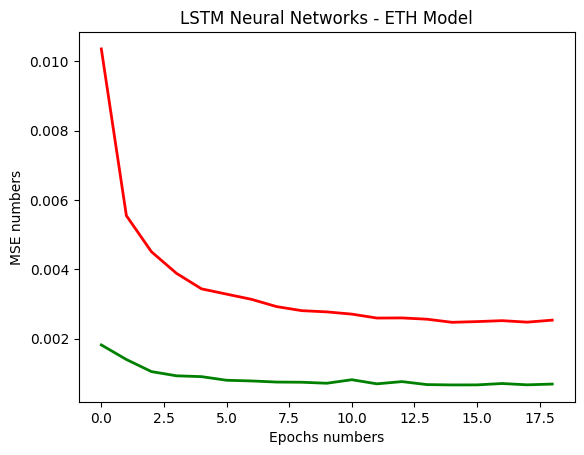

In [19]:
import matplotlib.pyplot as plt
plt.plot(modelfit_eth_univariate.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit_eth_univariate.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - ETH Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [20]:
x_train_eth_univariate[0:2]

array([[[ 0.        ],
        [-0.06741069],
        [-0.01933098],
        [-0.04043833],
        [-0.01298912],
        [ 0.05219023]],

       [[ 0.        ],
        [ 0.05155507],
        [ 0.02892201],
        [ 0.05835535],
        [ 0.12824607],
        [ 0.11396379]]])

In [21]:
x_train_eth_univariate.shape

(2108, 6, 1)

In [22]:
y_train_eth_univariate
y_train_eth_univariate[0:2]

array([0.03887072, 0.1058336 ])

In [23]:
y_train_eth_univariate.shape

(2108,)

## LPD for LSTM

In [24]:
def compute_lpd_lstm_dataframe(model, input_data, dates,window_len,debug=False):
    """
    Compute the Localized Prediction Differences (LPD) for a given Keras model, including date information.

    Args:
    - model: Trained Keras model.
    - input_data: Input data (pandas DataFrame) for which to compute the LPD.

    Returns:
    - LPDs: Localized Prediction Differences for each input data point, including date information.
    """
    # Extract dates from the input DataFrame

    assert len(dates) == input_data.shape[0], "The dates list must match the number of windows in X."
    # Ensure input_data is a TensorFlow tensor, excluding the date index for computation
    input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)

    # Initialize an empty list to store LPD for each data point
    lpd_list = []

    # Compute LPD for each data point
    for i in range(input_tensor.shape[0]):
        single_input_data = tf.expand_dims(input_tensor[i], axis=0)
        if debug:
          print("single_input_data\n",single_input_data)

        with tf.GradientTape() as tape:
            tape.watch(single_input_data)
            predictions = model(single_input_data)
            if debug:
              print("predictions\n",predictions)


        gradients = tape.gradient(predictions, single_input_data).numpy().reshape(1,window_len*input_data.shape[2])
        if debug:
          print("gradients\n",gradients)
        lpd_list.append(gradients)

    # Convert the list of LPDs to a NumPy array and then to a DataFrame
    lpd_array = tf.concat(lpd_list, axis=0).numpy()
    if debug:
      print("lpd_array:\n", lpd_array)
    lpd_df = pd.DataFrame(lpd_array, index=dates)

    return lpd_df



dates_univariate = train_data_eth.index[window_len:]
# Compute LPD and obtain a DataFrame
lpd_df_univariate = compute_lpd_lstm_dataframe(model_eth_univariate, x_train_eth_univariate,dates_univariate,window_len, debug=False)


# Display the LPD DataFrame
print(lpd_df_univariate.head())


                                  0         1         2         3         4  \
Date                                                                          
2017-11-15 00:00:00+00:00  0.027162  0.011346 -0.056263 -0.071824  0.239754   
2017-11-16 00:00:00+00:00  0.027602  0.015166 -0.054102 -0.081211  0.227684   
2017-11-17 00:00:00+00:00  0.027166  0.013232 -0.055527 -0.079203  0.231652   
2017-11-18 00:00:00+00:00  0.027541  0.015109 -0.054295 -0.080078  0.230553   
2017-11-19 00:00:00+00:00  0.027732  0.014917 -0.054201 -0.077456  0.233280   

                                  5  
Date                                 
2017-11-15 00:00:00+00:00  0.841074  
2017-11-16 00:00:00+00:00  0.846969  
2017-11-17 00:00:00+00:00  0.839641  
2017-11-18 00:00:00+00:00  0.843692  
2017-11-19 00:00:00+00:00  0.846466  


In [25]:
train_data_eth.shape

(2114, 5)

In [26]:
x_train_eth_univariate.shape

(2108, 6, 1)

## In sample LPD

The number of lines is equal to window_len*(number of columns we use like Close, Open ,...)

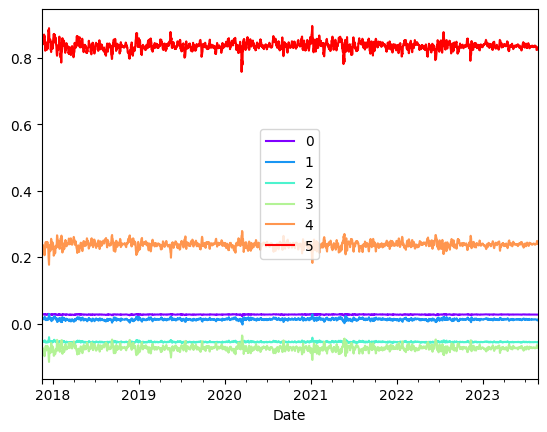

In [27]:
# Plotting in-sample LPD; replace `in_sample_lpd_df` with your actual LPD DataFrame
lpd_df_univariate.plot(colormap='rainbow')
plt.show()

## Out of sample LPD

In [28]:
x_test_eth_univariate.shape

(194, 6, 1)

In [29]:
test_data_eth.shape

(200, 5)

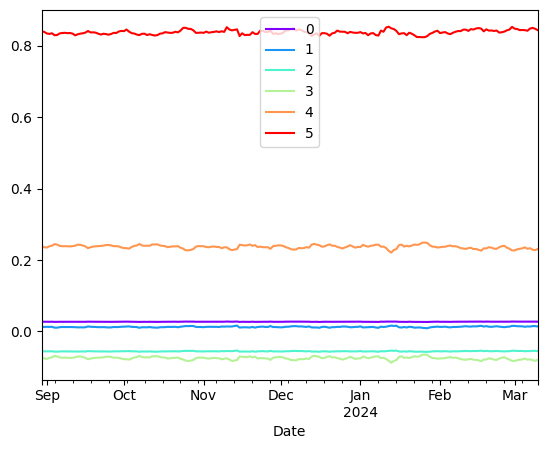

In [30]:
# Assuming the window length is 5

# Extract the dates corresponding to the end of each window
dates_univariate_test = test_data_eth.index[window_len:]

lpd_test_df_univariate = compute_lpd_lstm_dataframe(model_eth_univariate, x_test_eth_univariate, dates_univariate_test,window_len, debug=False)
lpd_test_df_univariate.plot(colormap='rainbow')
plt.show()


## Linear Regression (Flattened) vs LPD

In [31]:
train_data_eth.head(11)

,High,Low,Open,Volume,Close
Date,,,,,
2017-11-09 00:00:00+00:00,329.451996,307.056000,308.644989,893249984,320.884003
2017-11-10 00:00:00+00:00,324.717987,294.541992,320.670990,885985984,299.252991
2017-11-11 00:00:00+00:00,319.453003,298.191986,298.585999,842300992,314.681000
2017-11-12 00:00:00+00:00,319.153015,298.513000,314.690002,1613479936,307.907990
2017-11-13 00:00:00+00:00,328.415009,307.024994,307.024994,1041889984,316.716003
2017-11-14 00:00:00+00:00,340.177002,316.763000,316.763000,1069680000,337.631012
2017-11-15 00:00:00+00:00,340.911987,329.812988,337.963989,722665984,333.356995
2017-11-16 00:00:00+00:00,336.158997,323.605988,333.442993,797254016,330.924011
2017-11-17 00:00:00+00:00,334.963989,327.523010,330.166992,621732992,332.394012


In [32]:
x_train_eth_univariate[0]

array([[ 0.        ],
       [-0.06741069],
       [-0.01933098],
       [-0.04043833],
       [-0.01298912],
       [ 0.05219023]])

In [33]:
# Assuming X_train_eth_univariate.shape is (num_samples, window_len, num_features)
num_samples_univariate, window_len_univariate, num_features_univariate = x_train_eth_univariate.shape

# Flatten the 3D data to 2D
X_train_flat_univariate = x_train_eth_univariate.reshape((num_samples_univariate, window_len_univariate * num_features_univariate))
X_test_flat_univariate = x_test_eth_univariate.reshape((x_test_eth_univariate.shape[0], window_len_univariate * num_features_univariate))


In [34]:
X_train_flat_univariate.shape

(2108, 6)

In [35]:
y_train_eth_univariate.shape

(2108,)

In [36]:
# Assuming y_train_eth_univariate and x_train_eth_univariate are correctly defined
reg_model_univariate  = LinearRegression().fit(X_train_flat_univariate, y_train_eth_univariate)

# Regression coefficients
reg_coeffs_univariate = reg_model_univariate .coef_
print("Regression Coefficients:", reg_coeffs_univariate)



# Making predictions
y_pred_train_reg = reg_model_univariate.predict(X_train_flat_univariate)
y_pred_test_reg = reg_model_univariate.predict(X_test_flat_univariate)

# Comparing standard deviations of residuals from regression and your neural network model might require storing those residuals first
reg_residuals_std = np.std(y_pred_train_reg - y_train_eth_univariate)
print("Standard Deviation of Regression Residuals:", reg_residuals_std)


Regression Coefficients: [ 0.         -0.00144359  0.00326427 -0.03936512  0.05958896  0.99518189]
Standard Deviation of Regression Residuals: 0.04833284981198873


Unflatten the regression variables in the second axis to better compare with LPD:

In [37]:
lpd_df_univariate

,0,1,2,3,4,5
Date,,,,,,
2017-11-15 00:00:00+00:00,0.027162,0.011346,-0.056263,-0.071824,0.239754,0.841074
2017-11-16 00:00:00+00:00,0.027602,0.015166,-0.054102,-0.081211,0.227684,0.846969
2017-11-17 00:00:00+00:00,0.027166,0.013232,-0.055527,-0.079203,0.231652,0.839641
2017-11-18 00:00:00+00:00,0.027541,0.015109,-0.054295,-0.080078,0.230553,0.843692
2017-11-19 00:00:00+00:00,0.027732,0.014917,-0.054201,-0.077456,0.233280,0.846466
...,...,...,...,...,...,...
2023-08-19 00:00:00+00:00,0.026734,0.010914,-0.056477,-0.068363,0.245320,0.823481
2023-08-20 00:00:00+00:00,0.026732,0.010156,-0.056623,-0.064901,0.248645,0.824543
2023-08-21 00:00:00+00:00,0.026701,0.009784,-0.056681,-0.065356,0.247783,0.826338


In [38]:
# Assuming you've computed the LPD for your training data and stored it in a DataFrame named `lpd_train_df_univariate`
mean_lpd_univariate = lpd_df_univariate.mean(axis=0)
print("Reg Coeffs:", reg_coeffs_univariate)
print("Mean LPD:", mean_lpd_univariate.values)

Reg Coeffs: [ 0.         -0.00144359  0.00326427 -0.03936512  0.05958896  0.99518189]
Mean LPD: [ 0.02710392  0.01249554 -0.05552171 -0.07371714  0.23778814  0.8354984 ]


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM model evaluation
y_pred_test_lstm = model_eth_univariate.predict(x_test_eth_univariate).flatten()
mse_lstm = mean_squared_error(y_test_eth_univariate, y_pred_test_lstm)
mae_lstm = mean_absolute_error(y_test_eth_univariate, y_pred_test_lstm)

# Linear Regression model evaluation
mse_reg_univariate = mean_squared_error(y_test_eth_univariate, y_pred_test_reg)
mae_reg_univariate = mean_absolute_error(y_test_eth_univariate, y_pred_test_reg)

print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")
print(f"Linear Regression - MSE: {mse_reg_univariate}, MAE: {mae_reg_univariate}")


7/7 [==============================] - 1s 3ms/step
LSTM - MSE: 0.0006757808661775193, MAE: 0.01862753960694243
Linear Regression - MSE: 0.0006764578435424769, MAE: 0.018260165530514606


## Buy and Hold vs LPD:

In [40]:
lpd_df_univariate

,0,1,2,3,4,5
Date,,,,,,
2017-11-15 00:00:00+00:00,0.027162,0.011346,-0.056263,-0.071824,0.239754,0.841074
2017-11-16 00:00:00+00:00,0.027602,0.015166,-0.054102,-0.081211,0.227684,0.846969
2017-11-17 00:00:00+00:00,0.027166,0.013232,-0.055527,-0.079203,0.231652,0.839641
2017-11-18 00:00:00+00:00,0.027541,0.015109,-0.054295,-0.080078,0.230553,0.843692
2017-11-19 00:00:00+00:00,0.027732,0.014917,-0.054201,-0.077456,0.233280,0.846466
...,...,...,...,...,...,...
2023-08-19 00:00:00+00:00,0.026734,0.010914,-0.056477,-0.068363,0.245320,0.823481
2023-08-20 00:00:00+00:00,0.026732,0.010156,-0.056623,-0.064901,0.248645,0.824543
2023-08-21 00:00:00+00:00,0.026701,0.009784,-0.056681,-0.065356,0.247783,0.826338


Extracting Close Prices

First, extract the aim price series from your dataset. Since you're interested in applying Buy and Hold, you might use the last aim price of each window to represent that window's value. This simplifies the 3D structure into a 1D time series you can directly apply Buy and Hold to:

In [41]:
train_data_eth

,High,Low,Open,Volume,Close
Date,,,,,
2017-11-09 00:00:00+00:00,329.451996,307.056000,308.644989,893249984,320.884003
2017-11-10 00:00:00+00:00,324.717987,294.541992,320.670990,885985984,299.252991
2017-11-11 00:00:00+00:00,319.453003,298.191986,298.585999,842300992,314.681000
2017-11-12 00:00:00+00:00,319.153015,298.513000,314.690002,1613479936,307.907990
2017-11-13 00:00:00+00:00,328.415009,307.024994,307.024994,1041889984,316.716003
...,...,...,...,...,...
2023-08-19 00:00:00+00:00,1693.228149,1654.075806,1660.844360,4871231360,1669.471924
2023-08-20 00:00:00+00:00,1692.328735,1662.901489,1669.587769,4105056995,1684.852051
2023-08-21 00:00:00+00:00,1685.082642,1651.959839,1685.022339,5077248383,1667.269043


In [42]:
299.252991/320.884003-1

-0.0674106898373491

In [43]:
x_train_eth_univariate[0:2]

array([[[ 0.        ],
        [-0.06741069],
        [-0.01933098],
        [-0.04043833],
        [-0.01298912],
        [ 0.05219023]],

       [[ 0.        ],
        [ 0.05155507],
        [ 0.02892201],
        [ 0.05835535],
        [ 0.12824607],
        [ 0.11396379]]])

In [44]:
x_train_eth_univariate[:, -1, -1]

array([ 0.05219023,  0.11396379,  0.05161739, ..., -0.07777007,
       -0.07664238, -0.03029253])

In [45]:
log_returns_eth_univariate = np.log(train_data_eth[aim]).diff().dropna()
log_returns_test_eth_univariate = np.log(test_data_eth[aim]).diff().dropna()

In [46]:
log_returns_eth_univariate

Date
2017-11-10 00:00:00+00:00   -0.069790
2017-11-11 00:00:00+00:00    0.050270
2017-11-12 00:00:00+00:00   -0.021758
2017-11-13 00:00:00+00:00    0.028204
2017-11-14 00:00:00+00:00    0.063948
                               ...   
2023-08-19 00:00:00+00:00    0.005121
2023-08-20 00:00:00+00:00    0.009170
2023-08-21 00:00:00+00:00   -0.010491
2023-08-22 00:00:00+00:00   -0.020222
2023-08-23 00:00:00+00:00    0.027397
Name: Close, Length: 2113, dtype: float64

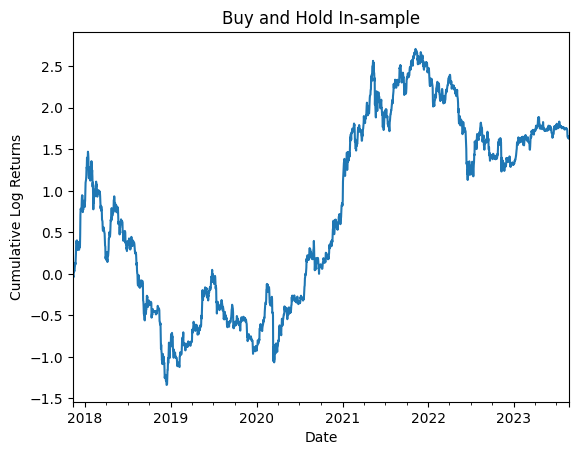

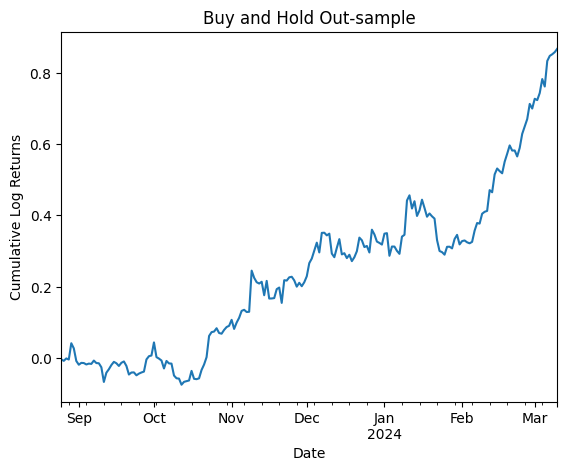

Initial price for training data: 
 320.8840026855469
Estimated final price for training data: 
 1679.2744140624986
Initial final price for testing data: 
 1659.944580078125
Estimated final price for testing data: 
 3952.8762207031236


In [47]:
# Assuming features_sorted and features_test_sorted are already defined and contain the log returns
# Calculate cumulative log returns
bh_out_eth_univariate = log_returns_test_eth_univariate.cumsum()
bh_in_eth_univariate = log_returns_eth_univariate.cumsum()

# Convert cumulative log returns to total growth factors
# This step is necessary if you want to translate these sums back to a price scale for interpretation
initial_price_train_eth_univariate = train_data_eth[aim].iloc[0]  # adjust based on your actual data
initial_price_test_eth_univariate = test_data_eth[aim].iloc[0]    # adjust based on your actual data

final_price_train_eth_univariate = initial_price_train_eth_univariate * np.exp(bh_in_eth_univariate.iloc[-1])
final_price_test_eth_univariate = initial_price_test_eth_univariate * np.exp(bh_out_eth_univariate.iloc[-1])

# Plotting Buy and Hold based on log of differences
bh_in_eth_univariate.plot(title='Buy and Hold In-sample', ylabel='Cumulative Log Returns')
plt.show()

bh_out_eth_univariate.plot(title='Buy and Hold Out-sample', ylabel='Cumulative Log Returns')
plt.show()
print("Initial price for training data: \n",initial_price_train_eth_univariate)
print("Estimated final price for training data: \n",final_price_train_eth_univariate)

print("Initial final price for testing data: \n",initial_price_test_eth_univariate)
print("Estimated final price for testing data: \n",final_price_test_eth_univariate)


### LPD Absolute Strategy Performance

The strategy involves using the upper and lower quantiles of the absolute values of LPD to decide on market entries and exits. This strategy requires calculating rolling quantiles

### Quantiles

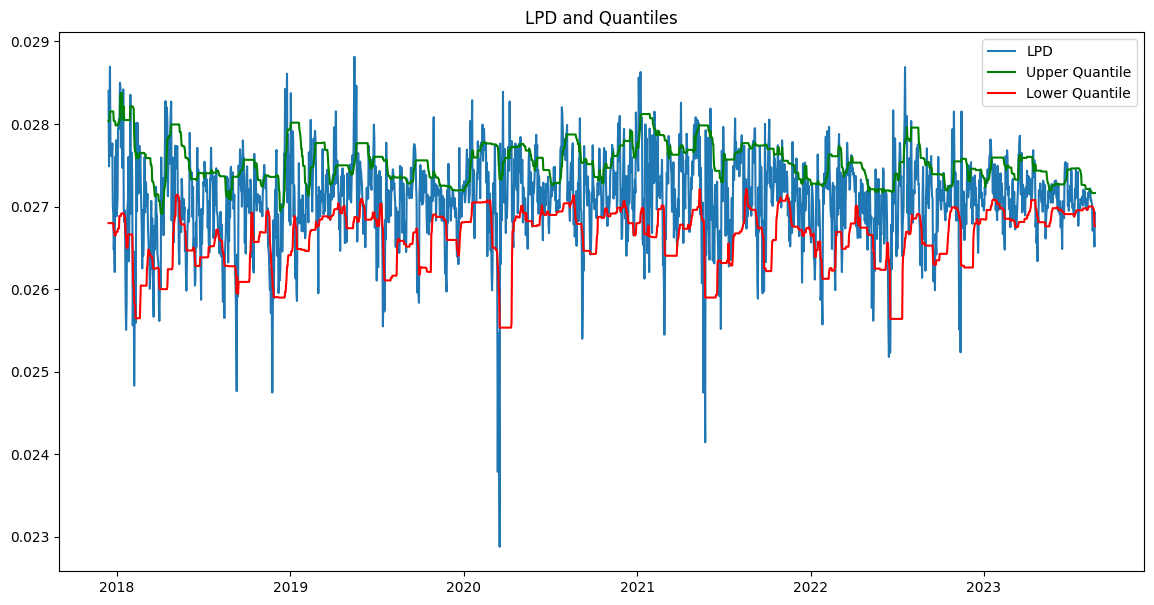

In [48]:
# Example DataFrame of LPDs (assuming LPD_t is your DataFrame of LPDs)
LPD_t = lpd_df_univariate # Your actual LPD DataFrame goes here


# Use absolute values of LPD
abs_LPD_t = LPD_t.abs()

# Rolling quantiles
roll_quant_up = abs_LPD_t.iloc[:, k-1].rolling(window=length_roll_quantile).quantile(quantile_select)
roll_quant_low = abs_LPD_t.iloc[:, k-1].rolling(window=length_roll_quantile).quantile(1 - quantile_select)

# Plotting LPD with upper and lower quantiles
plt.figure(figsize=(14, 7))
plt.plot(abs_LPD_t.iloc[length_roll_quantile-1:,].index, abs_LPD_t.iloc[length_roll_quantile-1:, k-1], label='LPD')
plt.plot(roll_quant_up.index, roll_quant_up, label='Upper Quantile', color='green')
plt.plot(roll_quant_low.index, roll_quant_low, label='Lower Quantile', color='red')
plt.legend()
plt.title('LPD and Quantiles')
plt.show()


    Exit the market if the absolute LPD is above the upper quantile or below the lower quantile (signifying high risk).
    Enter (or stay in) the market otherwise.

In [49]:
abs_LPD_t

,0,1,2,3,4,5
Date,,,,,,
2017-11-15 00:00:00+00:00,0.027162,0.011346,0.056263,0.071824,0.239754,0.841074
2017-11-16 00:00:00+00:00,0.027602,0.015166,0.054102,0.081211,0.227684,0.846969
2017-11-17 00:00:00+00:00,0.027166,0.013232,0.055527,0.079203,0.231652,0.839641
2017-11-18 00:00:00+00:00,0.027541,0.015109,0.054295,0.080078,0.230553,0.843692
2017-11-19 00:00:00+00:00,0.027732,0.014917,0.054201,0.077456,0.233280,0.846466
...,...,...,...,...,...,...
2023-08-19 00:00:00+00:00,0.026734,0.010914,0.056477,0.068363,0.245320,0.823481
2023-08-20 00:00:00+00:00,0.026732,0.010156,0.056623,0.064901,0.248645,0.824543
2023-08-21 00:00:00+00:00,0.026701,0.009784,0.056681,0.065356,0.247783,0.826338


In [50]:
log_returns_eth_univariate

Date
2017-11-10 00:00:00+00:00   -0.069790
2017-11-11 00:00:00+00:00    0.050270
2017-11-12 00:00:00+00:00   -0.021758
2017-11-13 00:00:00+00:00    0.028204
2017-11-14 00:00:00+00:00    0.063948
                               ...   
2023-08-19 00:00:00+00:00    0.005121
2023-08-20 00:00:00+00:00    0.009170
2023-08-21 00:00:00+00:00   -0.010491
2023-08-22 00:00:00+00:00   -0.020222
2023-08-23 00:00:00+00:00    0.027397
Name: Close, Length: 2113, dtype: float64

In [51]:
log_returns_eth_univariate[window_len:]

Date
2017-11-16 00:00:00+00:00   -0.007325
2017-11-17 00:00:00+00:00    0.004432
2017-11-18 00:00:00+00:00    0.044766
2017-11-19 00:00:00+00:00    0.019300
2017-11-20 00:00:00+00:00    0.034239
                               ...   
2023-08-19 00:00:00+00:00    0.005121
2023-08-20 00:00:00+00:00    0.009170
2023-08-21 00:00:00+00:00   -0.010491
2023-08-22 00:00:00+00:00   -0.020222
2023-08-23 00:00:00+00:00    0.027397
Name: Close, Length: 2107, dtype: float64

### Simulate Strategy

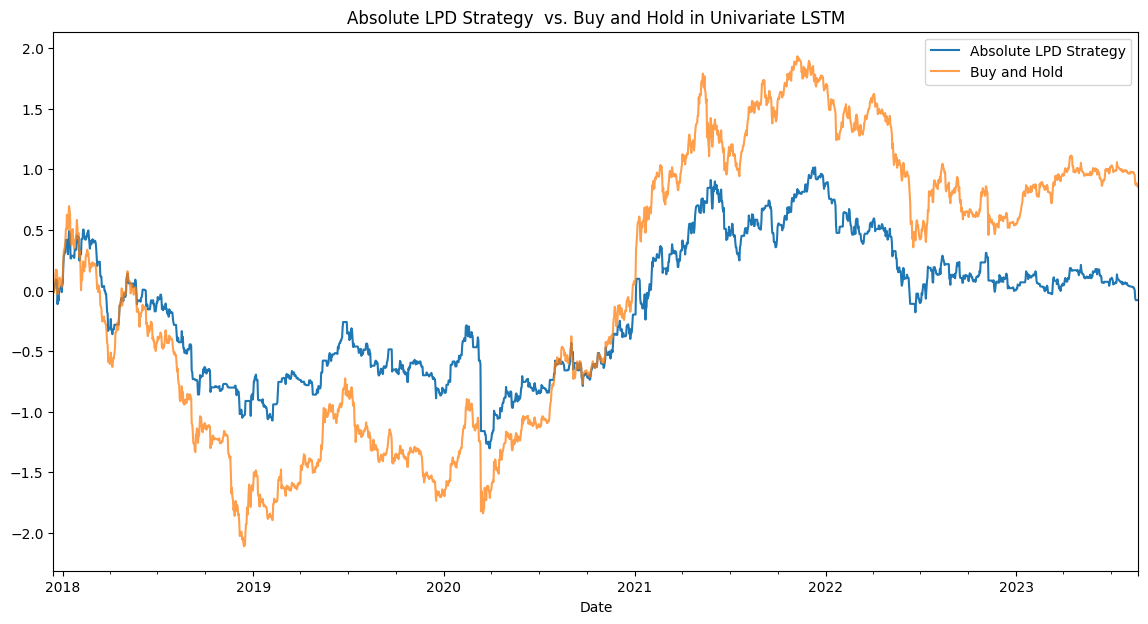

In [52]:
def simulate_strategy(abs_lpd_series, roll_quant_up, roll_quant_low, daily_returns):
    # Determine positions: 1 for holding the asset, 0 for exiting the market
    positions = ((abs_lpd_series <= roll_quant_up) & (abs_lpd_series >= roll_quant_low)).astype(int)
    # Calculate daily strategy returns by uniplying positions with daily returns
    strategy_returns = positions.shift(1) * daily_returns  # Shift positions to reflect action taken at the end of the day
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns

# Simulate the strategy
daily_returns_abs_in_sample_lstm = log_returns_eth_univariate[window_len:].iloc[length_roll_quantile-1:]
cumulative_returns_abs_in_sample_lstm = simulate_strategy(abs_LPD_t.iloc[:,k-1].iloc[length_roll_quantile-1:], roll_quant_up.iloc[length_roll_quantile-1:], roll_quant_low.iloc[length_roll_quantile-1:], daily_returns_abs_in_sample_lstm)

# Plot the cumulative returns of the strategy against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_abs_in_sample_lstm.plot(label='Absolute LPD Strategy', legend=True)
daily_returns_abs_in_sample_lstm.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Absolute LPD Strategy  vs. Buy and Hold in Univariate LSTM')
plt.show()


# daily_returns = close_prices_test_series
# cumulative_returns = simulate_strategy(abs_LPD_t[k], roll_quant_up, roll_quant_low, daily_returns)
# # Plot the cumulative returns of the strategy against buy-and-hold
# plt.figure(figsize=(14, 7))
# cumulative_returns.plot(label='RM Strategy', legend=True)
# daily_returns.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
# plt.title('RM Strategy vs. Buy and Hold')
# plt.show()

In [53]:
lpd_test_df_univariate

,0,1,2,3,4,5
Date,,,,,,
2023-08-30 00:00:00+00:00,0.027287,0.012456,-0.055653,-0.073432,0.238297,0.840004
2023-08-31 00:00:00+00:00,0.027200,0.012801,-0.055531,-0.075368,0.235563,0.838015
2023-09-01 00:00:00+00:00,0.027057,0.012921,-0.055619,-0.076798,0.234830,0.833754
2023-09-02 00:00:00+00:00,0.027077,0.012674,-0.055735,-0.074131,0.238306,0.832584
2023-09-03 00:00:00+00:00,0.027274,0.013006,-0.055305,-0.072237,0.240120,0.834356
...,...,...,...,...,...,...
2024-03-06 00:00:00+00:00,0.027382,0.014134,-0.054803,-0.078854,0.231315,0.841410
2024-03-07 00:00:00+00:00,0.027549,0.013766,-0.055025,-0.077892,0.232927,0.847540
2024-03-08 00:00:00+00:00,0.027679,0.015039,-0.054171,-0.080180,0.228820,0.849358


In [54]:
LPD_t_test = lpd_test_df_univariate # Your actual LPD DataFrame goes here

# Use absolute values of LPD
abs_LPD_t_test = LPD_t_test.abs()

# Extend test data by last month of train data
last_month_train_lpd = LPD_t.iloc[-length_roll_quantile:]
LPD_t_test = pd.concat([last_month_train_lpd, LPD_t_test])
abs_LPD_t_test=LPD_t_test.abs()
print(LPD_t_test)


                                  0         1         2         3         4  \
Date                                                                          
2023-07-25 00:00:00+00:00  0.027033  0.012113 -0.055889 -0.072603  0.239482   
2023-07-26 00:00:00+00:00  0.027033  0.011918 -0.055990 -0.072299  0.240110   
2023-07-27 00:00:00+00:00  0.027054  0.011803 -0.056036 -0.071665  0.240575   
2023-07-28 00:00:00+00:00  0.027127  0.012381 -0.055706 -0.073221  0.238689   
2023-07-29 00:00:00+00:00  0.027011  0.011692 -0.056139 -0.072405  0.239788   
...                             ...       ...       ...       ...       ...   
2024-03-06 00:00:00+00:00  0.027382  0.014134 -0.054803 -0.078854  0.231315   
2024-03-07 00:00:00+00:00  0.027549  0.013766 -0.055025 -0.077892  0.232927   
2024-03-08 00:00:00+00:00  0.027679  0.015039 -0.054171 -0.080180  0.228820   
2024-03-09 00:00:00+00:00  0.027552  0.015009 -0.054312 -0.082111  0.227350   
2024-03-10 00:00:00+00:00  0.027349  0.013936 -0.055

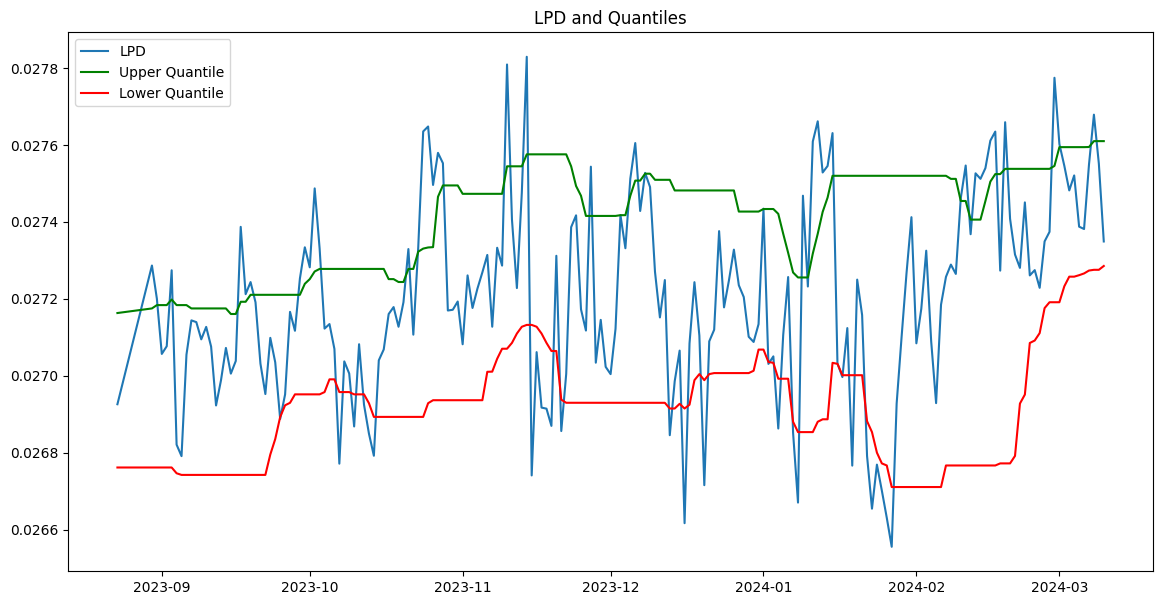

In [55]:

# Rolling quantiles
roll_quant_up_test = abs_LPD_t_test.iloc[:, k-1].rolling(window=length_roll_quantile).quantile(quantile_select)
roll_quant_low_test = abs_LPD_t_test.iloc[:, k-1].rolling(window=length_roll_quantile).quantile(1 - quantile_select)

# Plotting LPD with upper and lower quantiles
plt.figure(figsize=(14, 7))
plt.plot(abs_LPD_t_test.iloc[length_roll_quantile-1:,].index, abs_LPD_t_test.iloc[length_roll_quantile-1:, k-1], label='LPD')
plt.plot(roll_quant_up_test.index, roll_quant_up_test, label='Upper Quantile', color='green')
plt.plot(roll_quant_low_test.index, roll_quant_low_test, label='Lower Quantile', color='red')
plt.legend()
plt.title('LPD and Quantiles')
plt.show()


In [56]:
roll_quant_up_test

Date
2023-07-25 00:00:00+00:00         NaN
2023-07-26 00:00:00+00:00         NaN
2023-07-27 00:00:00+00:00         NaN
2023-07-28 00:00:00+00:00         NaN
2023-07-29 00:00:00+00:00         NaN
                               ...   
2024-03-06 00:00:00+00:00    0.027594
2024-03-07 00:00:00+00:00    0.027595
2024-03-08 00:00:00+00:00    0.027610
2024-03-09 00:00:00+00:00    0.027610
2024-03-10 00:00:00+00:00    0.027610
Name: 0, Length: 224, dtype: float64

In [57]:
log_returns_test_eth_univariate[window_len:]

Date
2023-08-31 00:00:00+00:00   -0.035502
2023-09-01 00:00:00+00:00   -0.010475
2023-09-02 00:00:00+00:00    0.005227
2023-09-03 00:00:00+00:00   -0.000555
2023-09-04 00:00:00+00:00   -0.003958
                               ...   
2024-03-06 00:00:00+00:00    0.071703
2024-03-07 00:00:00+00:00    0.014329
2024-03-08 00:00:00+00:00    0.004562
2024-03-09 00:00:00+00:00    0.005983
2024-03-10 00:00:00+00:00    0.009521
Name: Close, Length: 193, dtype: float64

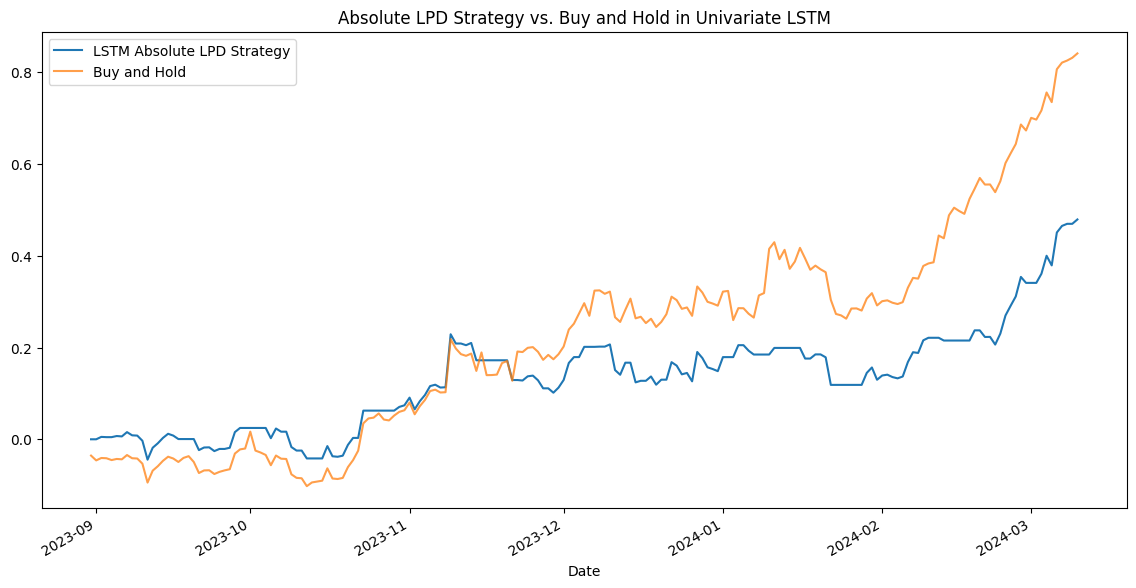

In [58]:
def simulate_strategy(abs_lpd_series, roll_quant_up, roll_quant_low, daily_returns):
    # Determine positions: 1 for holding the asset, 0 for exiting the market
    positions = ((abs_lpd_series <= roll_quant_up) & (abs_lpd_series >= roll_quant_low)).astype(int)
    # Calculate daily strategy returns by uniplying positions with daily returns
    strategy_returns = positions.shift(1) * daily_returns  # Shift positions to reflect action taken at the end of the day
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns


# Simulate the strategy
daily_returns_test_abs_out_sample_lstm =  log_returns_test_eth_univariate[window_len:]
cumulative_returns_test_abs_out_sample_lstm = simulate_strategy(abs_LPD_t_test.iloc[:,k-1].iloc[length_roll_quantile-1:], roll_quant_up_test.iloc[length_roll_quantile-1:], roll_quant_low_test.iloc[length_roll_quantile-1:], daily_returns_test_abs_out_sample_lstm)

# Plot the cumulative returns of the strategy against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_test_abs_out_sample_lstm.plot(label='LSTM Absolute LPD Strategy', legend=True)
daily_returns_test_abs_out_sample_lstm.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Absolute LPD Strategy vs. Buy and Hold in Univariate LSTM')
plt.show()


# daily_returns = close_prices_test_series
# cumulative_returns = simulate_strategy(abs_LPD_t[k], roll_quant_up, roll_quant_low, daily_returns)
# # Plot the cumulative returns of the strategy against buy-and-hold
# plt.figure(figsize=(14, 7))
# cumulative_returns.plot(label='RM Strategy', legend=True)
# daily_returns.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
# plt.title('RM Strategy vs. Buy and Hold')
# plt.show()

Out sample

In [59]:
daily_returns_test_abs_out_sample_lstm

Date
2023-08-31 00:00:00+00:00   -0.035502
2023-09-01 00:00:00+00:00   -0.010475
2023-09-02 00:00:00+00:00    0.005227
2023-09-03 00:00:00+00:00   -0.000555
2023-09-04 00:00:00+00:00   -0.003958
                               ...   
2024-03-06 00:00:00+00:00    0.071703
2024-03-07 00:00:00+00:00    0.014329
2024-03-08 00:00:00+00:00    0.004562
2024-03-09 00:00:00+00:00    0.005983
2024-03-10 00:00:00+00:00    0.009521
Name: Close, Length: 193, dtype: float64

### In Sample Sharpe Ratio

In [60]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * 252
    annualized_std = excess_returns.std() * np.sqrt(252)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_abs_in_sample = calculate_sharpe_ratio(daily_returns_abs_in_sample_lstm)
sharpe_ratio_var_strategy_abs_in_sample = calculate_sharpe_ratio(cumulative_returns_abs_in_sample_lstm.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_abs_in_sample:.2f}")
print(f"Sharpe Ratio - abs-Based Strategy: {sharpe_ratio_var_strategy_abs_in_sample:.2f}")


Sharpe Ratio - Buy and Hold: 0.14
Sharpe Ratio - abs-Based Strategy: -0.02


### Out Sample Sharpe Ratio

In [61]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * 252
    annualized_std = excess_returns.std() * np.sqrt(252)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_abs_out_sample = calculate_sharpe_ratio(daily_returns_test_abs_out_sample_lstm)
sharpe_ratio_var_strategy_test_abs_out_sample = calculate_sharpe_ratio(cumulative_returns_test_abs_out_sample_lstm.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_abs_out_sample:.2f}")
print(f"Sharpe Ratio - abs-Based Strategy: {sharpe_ratio_var_strategy_test_abs_out_sample:.2f}")


Sharpe Ratio - Buy and Hold: 2.77
Sharpe Ratio - abs-Based Strategy: 2.05


## Random networks

In [62]:
def random_lpd_list_lstm(x_train_eth_univariate,y_train_eth_univariate,x_test_eth_univariate,y_test_eth_univariate):
  random_lpd_list = []
  random_lpd_list_test = []
  num_nets = 2  # Number of random networks to train

  for i in range(num_nets):
      # Set the random seed for reproducibility
      np.random.seed(i)
      tf.random.set_seed(i)





      model_eth = build_lstm_model(
          input_data=x_train_eth_univariate, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
          optimizer=optimizer)

      modelfit_eth = model_eth.fit(
          x_train_eth_univariate, y_train_eth_univariate, validation_data=(x_test_eth_univariate, y_test_eth_univariate),
          epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

      # feature_names = ['High', 'Low', 'Open', 'Volume', aim]
      # Assuming the window length is 6
      # Extract the dates corresponding to the end of each window
      dates = train_data_eth.index[window_len:]
      dates_test = test_data_eth.index[window_len:]
      # Now call the function with the dates
      lpd_train_df_univariate = compute_lpd_lstm_dataframe(model_eth, x_train_eth_univariate, dates,window_len, debug=False)
      lpd_test_df_univariate = compute_lpd_lstm_dataframe(model_eth, x_test_eth_univariate,  dates_test,window_len, debug=False)
      lpd_train_df_univariate,lpd_test_df_univariate

      random_lpd_list.append(lpd_train_df_univariate)
      random_lpd_list_test.append(lpd_test_df_univariate)
  return random_lpd_list,random_lpd_list_test

In [63]:
random_lpd_list,random_lpd_list_test=random_lpd_list_lstm(x_train_eth_univariate,y_train_eth_univariate,x_test_eth_univariate,y_test_eth_univariate)

# Concatenate all LPD DataFrames along a new dimension
all_lpd_stack = np.dstack([df.values for df in random_lpd_list])  # Shape: [num_samples, num_features, num_models]
all_lpd_stack_test = np.dstack([df.values for df in random_lpd_list_test])  # Shape: [num_samples, num_features, num_models]

# Compute mean and standard deviation across the models (last dimension)
mean_lpd = np.mean(all_lpd_stack, axis=2)
std_lpd = np.std(all_lpd_stack, axis=2)

# Convert mean and STD back to DataFrame for easy plotting
mean_lpd_df = pd.DataFrame(mean_lpd, index=random_lpd_list[0].index, columns=random_lpd_list[0].columns)
std_lpd_df = pd.DataFrame(std_lpd, index=random_lpd_list[0].index, columns=random_lpd_list[0].columns)


# Compute mean and standard deviation across the models (last dimension)
mean_lpd_test = np.mean(all_lpd_stack_test, axis=2)
std_lpd_test = np.std(all_lpd_stack_test, axis=2)

# Convert mean and STD back to DataFrame for easy plotting
mean_lpd_df_test = pd.DataFrame(mean_lpd_test, index=random_lpd_list_test[0].index, columns=random_lpd_list_test[0].columns)
std_lpd_df = pd.DataFrame(std_lpd_test, index=random_lpd_list_test[0].index, columns=random_lpd_list_test[0].columns)


Epoch 1/20
66/66 [==============================] - 3s 13ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 2/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 3/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 8.7971e-04
Epoch 4/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 8.5472e-04
Epoch 5/20
66/66 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 8.8785e-04
Epoch 6/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 7.4644e-04
Epoch 7/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 7.0763e-04
Epoch 8/20
66/66 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 7.0454e-04
Epoch 9/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 7.0526e-04
Epoch 10/20
66/66 [==============================] - 0s 5ms/step - loss: 0.0026 - val_los

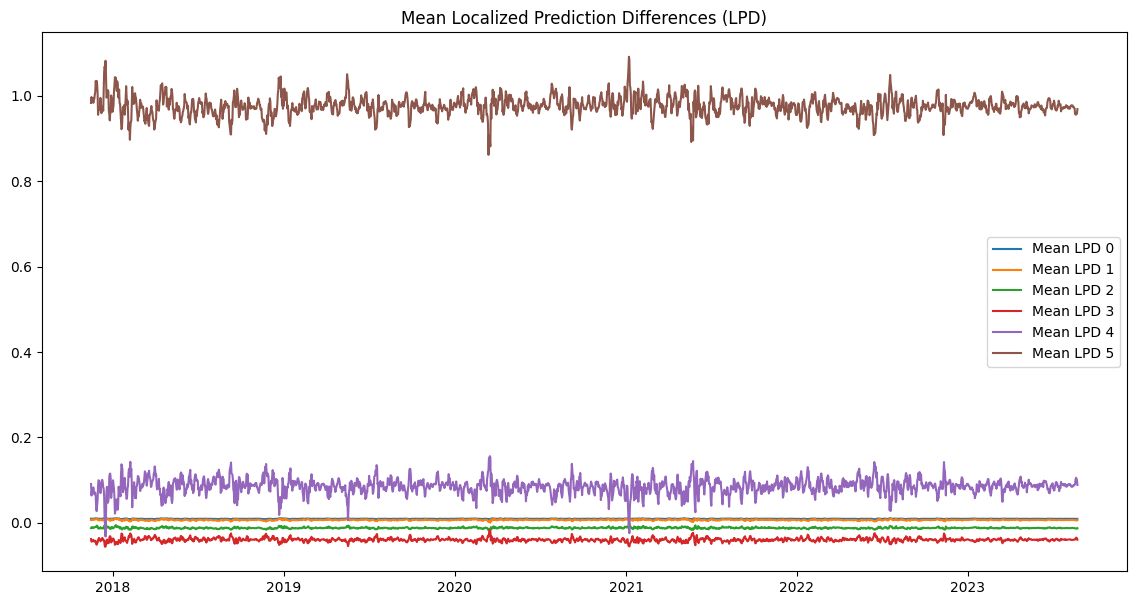

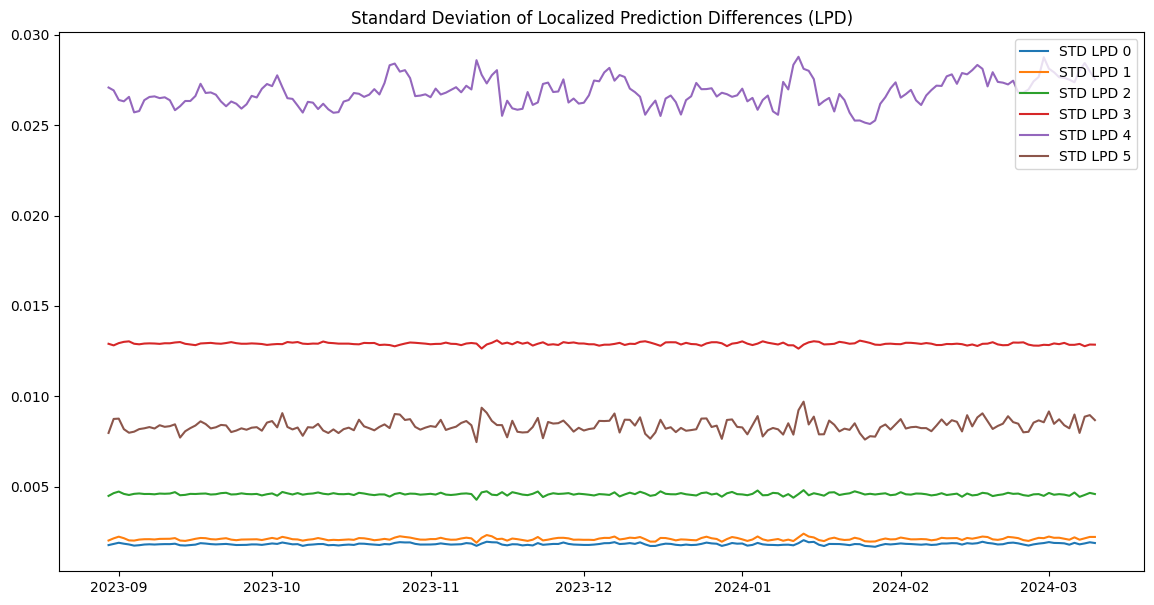

In [64]:
# Plot Mean LPD
plt.figure(figsize=(14, 7))
for col in mean_lpd_df.columns:
    plt.plot(mean_lpd_df.index, mean_lpd_df[col], label=f'Mean LPD {col}')
plt.title('Mean Localized Prediction Differences (LPD)')
plt.legend()
plt.show()

# Plot STD LPD
plt.figure(figsize=(14, 7))
for col in std_lpd_df.columns:
    plt.plot(std_lpd_df.index, std_lpd_df[col], label=f'STD LPD {col}')
plt.title('Standard Deviation of Localized Prediction Differences (LPD)')
plt.legend()
plt.show()


### LPD variance Strategy

In [65]:
# Compute variance across the models (last dimension)
LPD_var = np.var(all_lpd_stack, axis=2)

# Assuming the index from your LPD dataframes can represent the dates or sequence
LPD_var_df = pd.DataFrame(LPD_var, index=random_lpd_list[0].index, columns=random_lpd_list[0].columns)


In [66]:
# Compute variance across the models (last dimension)
LPD_var_test = np.var(all_lpd_stack_test, axis=2)

# Assuming the index from your LPD dataframes can represent the dates or sequence
LPD_var_df_test = pd.DataFrame(LPD_var_test, index=random_lpd_list_test[0].index, columns=random_lpd_list_test[0].columns)


In [67]:
LPD_var

array([[2.8891352e-06, 3.9450301e-06, 1.9627763e-05, 1.6313914e-04,
        7.3709246e-04, 6.2768377e-05],
       [3.6344218e-06, 4.7994645e-06, 2.1776706e-05, 1.6370596e-04,
        7.8841939e-04, 8.4750929e-05],
       [3.5851760e-06, 5.0584385e-06, 2.1869930e-05, 1.6556395e-04,
        7.3084608e-04, 7.7254430e-05],
       ...,
       [2.8435188e-06, 3.7738853e-06, 2.0970336e-05, 1.6678660e-04,
        6.4328377e-04, 6.1021652e-05],
       [2.9462481e-06, 4.2101883e-06, 2.1579808e-05, 1.6421688e-04,
        6.3721050e-04, 6.6745146e-05],
       [3.3071506e-06, 4.5681145e-06, 2.1681768e-05, 1.6709366e-04,
        6.7771744e-04, 7.0223330e-05]], dtype=float32)

In [68]:
LPD_var_df

,0,1,2,3,4,5
Date,,,,,,
2017-11-15 00:00:00+00:00,0.000003,0.000004,0.000020,0.000163,0.000737,0.000063
2017-11-16 00:00:00+00:00,0.000004,0.000005,0.000022,0.000164,0.000788,0.000085
2017-11-17 00:00:00+00:00,0.000004,0.000005,0.000022,0.000166,0.000731,0.000077
2017-11-18 00:00:00+00:00,0.000004,0.000005,0.000021,0.000168,0.000770,0.000072
2017-11-19 00:00:00+00:00,0.000003,0.000004,0.000020,0.000169,0.000788,0.000065
...,...,...,...,...,...,...
2023-08-19 00:00:00+00:00,0.000003,0.000004,0.000021,0.000171,0.000634,0.000060
2023-08-20 00:00:00+00:00,0.000003,0.000004,0.000021,0.000169,0.000638,0.000058
2023-08-21 00:00:00+00:00,0.000003,0.000004,0.000021,0.000167,0.000643,0.000061


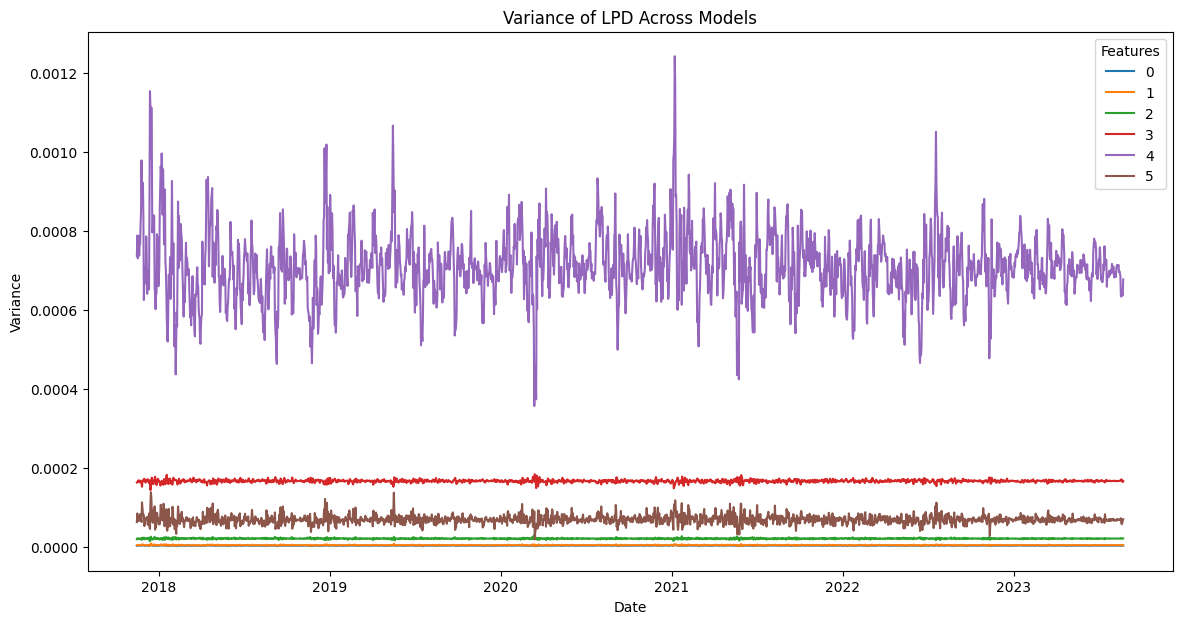

In [69]:
plt.figure(figsize=(14, 7))
for column in LPD_var_df.columns:
    plt.plot(LPD_var_df.index, LPD_var_df[column], label=column)
plt.legend(title="Features")
plt.title("Variance of LPD Across Models")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.show()


#### Strategy Implementation

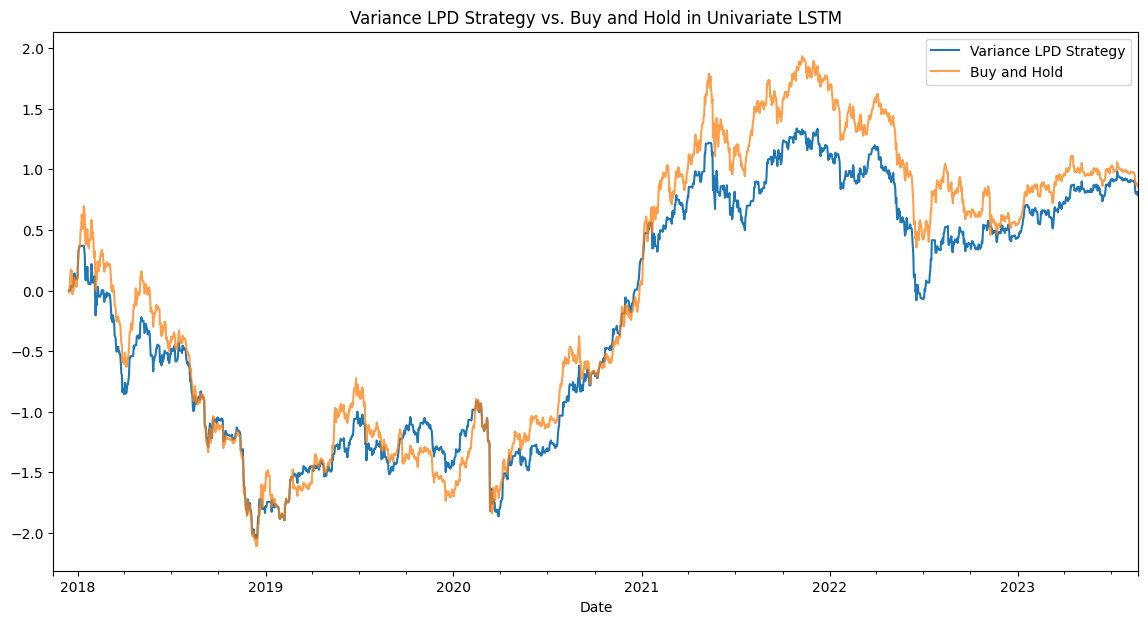

In [70]:
def simulate_variance_strategy(daily_returns, LPD_variance, threshold):
    """
    Simulate a trading strategy based on LPD variance.
    Args:
        daily_returns (pd.Series): The daily returns of the asset.
        LPD_variance (pd.Series): The variance of LPD for a specific feature.
        threshold (float): The variance threshold for deciding market entry/exit.
    Returns:
        pd.Series: The cumulative returns of the strategy.
    """
    # Market position: 1 for in-market, 0 for out-of-market
    position = (LPD_variance < threshold).astype(int)
    strategy_returns = position.shift(1) * daily_returns  # Shift positions for real trading scenario
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns



# Example usage with aim variance and an arbitrary threshold
variance_threshold = LPD_var_df.iloc[:,k-1].quantile(0.75)  # Using the 75th percentile as threshold
cumulative_returns_var_strategy_var_in_sample = simulate_variance_strategy(
    daily_returns=daily_returns_abs_in_sample_lstm,
    LPD_variance=LPD_var_df.iloc[:,k-1],
    threshold=variance_threshold
)

# Plotting the strategy returns against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_var_strategy_var_in_sample.plot(label='Variance LPD Strategy', legend=True)
daily_returns_abs_in_sample_lstm.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Variance LPD Strategy vs. Buy and Hold in Univariate LSTM')
plt.show()


Key Notes:

The risk_free_rate is set to 0 for simplicity. If you have a specific risk-free rate in mind (e.g., the yield on a 3-month Treasury bill), you can adjust the risk_free_rate parameter accordingly.
The function cumulative_returns_var_strategy.diff() calculates the daily returns from the cumulative returns of the variance-based strategy for the Sharpe Ratio calculation.
The returns and standard deviation are annualized by assuming there are 252 trading days in a year, which is standard practice.

##### IN Sample Sharpe Ratio

In [71]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * 252
    annualized_std = excess_returns.std() * np.sqrt(252)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold = calculate_sharpe_ratio(daily_returns_abs_in_sample_lstm)
sharpe_ratio_var_strategy = calculate_sharpe_ratio(cumulative_returns_var_strategy_var_in_sample.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold:.2f}")
print(f"Sharpe Ratio - Variance-Based Strategy: {sharpe_ratio_var_strategy:.2f}")


Sharpe Ratio - Buy and Hold: 0.14
Sharpe Ratio - Variance-Based Strategy: 0.15


The buy and hold is positve and therefor better than variance based strategy

Sharpe Ratio for absolute LPDs

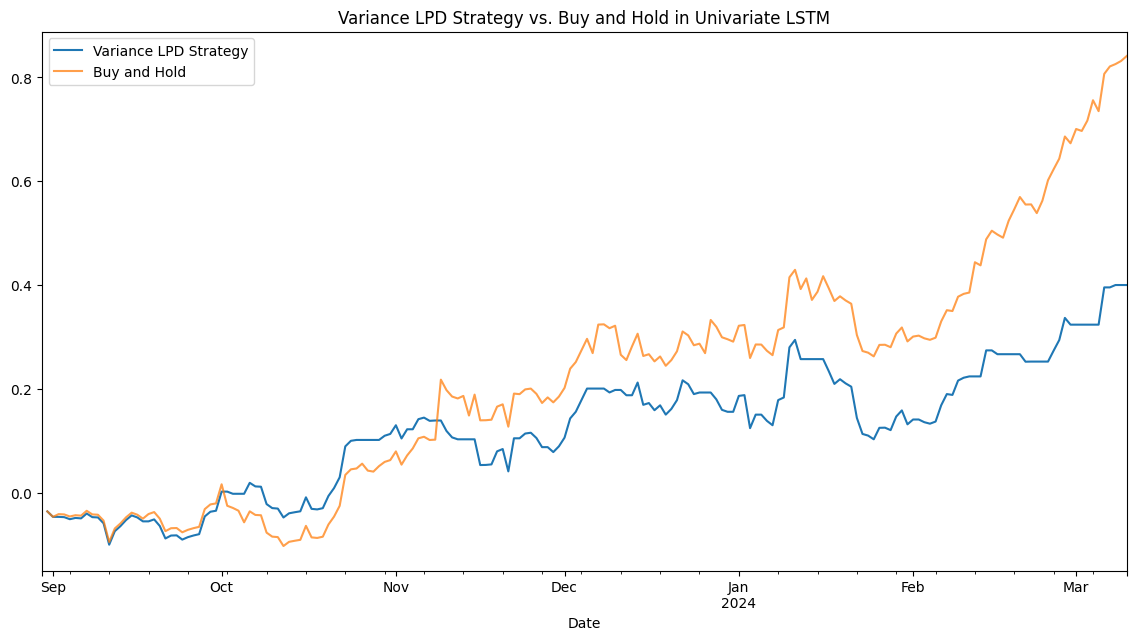

In [72]:
def simulate_variance_strategy(daily_returns, LPD_variance, threshold):
    """
    Simulate a trading strategy based on LPD variance.
    Args:
        daily_returns (pd.Series): The daily returns of the asset.
        LPD_variance (pd.Series): The variance of LPD for a specific feature.
        threshold (float): The variance threshold for deciding market entry/exit.
    Returns:
        pd.Series: The cumulative returns of the strategy.
    """
    # Market position: 1 for in-market, 0 for out-of-market
    position = (LPD_variance < threshold).astype(int)
    strategy_returns = position.shift(1) * daily_returns  # Shift positions for real trading scenario
    cumulative_returns = strategy_returns.cumsum()
    return cumulative_returns



# Example usage with aim variance and an arbitrary threshold
variance_threshold_test = LPD_var_df_test.iloc[:,k-1].quantile(0.75)  # Using the 75th percentile as threshold
cumulative_returns_var_strategy_test_var_out_sample = simulate_variance_strategy(
    daily_returns=daily_returns_test_abs_out_sample_lstm,
    LPD_variance=LPD_var_df_test.iloc[:,k-1],
    threshold=variance_threshold_test
)

# Plotting the strategy returns against buy-and-hold
plt.figure(figsize=(14, 7))
cumulative_returns_var_strategy_test_var_out_sample.plot(label='Variance LPD Strategy', legend=True)
daily_returns_test_abs_out_sample_lstm.cumsum().plot(label='Buy and Hold', legend=True, alpha=0.75)
plt.title('Variance LPD Strategy vs. Buy and Hold in Univariate LSTM')
plt.show()


##### Out Sample Sharpe Ratio

In [73]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a series of daily returns.
    Args:
        daily_returns (pd.Series): Daily returns of the strategy.
        risk_free_rate (float): Daily risk-free rate, default is 0.
    Returns:
        float: The Sharpe Ratio.
    """
    # Adjust returns for risk-free rate
    excess_returns = daily_returns - risk_free_rate

    # Annualize the returns and standard deviation
    annualized_return = excess_returns.mean() * 252
    annualized_std = excess_returns.std() * np.sqrt(252)

    return annualized_return / annualized_std

# Calculate Sharpe Ratios
sharpe_ratio_buy_and_hold_test_var_out_sample = calculate_sharpe_ratio(daily_returns_test_abs_out_sample_lstm)
sharpe_ratio_var_strategy_test_var_out_sample = calculate_sharpe_ratio(cumulative_returns_var_strategy_test_var_out_sample.diff())

# Print Sharpe Ratios
print(f"Sharpe Ratio - Buy and Hold: {sharpe_ratio_buy_and_hold_test_var_out_sample:.2f}")
print(f"Sharpe Ratio - Variance-Based Strategy: {sharpe_ratio_var_strategy_test_var_out_sample:.2f}")


Sharpe Ratio - Buy and Hold: 2.77
Sharpe Ratio - Variance-Based Strategy: 1.82


# Conclusion